In [1]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")

<h1 align="center"> 
Predicting the Cause of Wildfires 
</h1> 
<h2 align="center"> 
#2-Predicting Categorized Cause of Wildfire
</h2>
<h3 align="center"> 
DATS 6501_10, Spring 2019, Capstone (Machine Learning)
</h3>
<h4 align="center"> 
Author: Jiajun Wu
</h4>

### Problem definition and motivation
We chosen to explore Spatial wildfire occurrence data for the United States, 1992-2015, which consists of 1,880,465 records and 39 attributes. We plan to use a data science approach to analyzing the wildfire data in order to predict the cause of wildfire, based on the variety of features in the database. Our motivation for this project is tov apply the machine learing models we have learned in class onto a real-world data set. 

### Proposed method, language, and package for implementation
The project aims to use Python to analyze the wildfire data. Specific packages to be used are Numpy, Pandas, and Scikit-learn. We will use Matplotlib for visualizations. For the methods the team plans to use to make our predictor, we’ll be trying neural net, and then two methods covered later in class: Random Forest and Support Vector Machine (SVM).

### Link to the data
https://www.fs.usda.gov/rds/archive/Product/RDS-2013-0009.4/


#### Part 1: import libraries and data, convert dates to Gregorian format
#### Part 2: EDA
#### Part 3: Use machine learning to predict the cause of the fires
#### Part 4: Build a system that predicts if the fire was malicious




# Data Preprocess 
### Same like "#1-Predicting Uncategorized Cause of Wildfire"

In [2]:
#Load the data 
sqlite_file = "FPA_FOD_20170508.sqlite"
conn=sqlite3.connect(sqlite_file)
c = conn.cursor()
fires = pd.read_sql_query("SELECT * FROM fires", conn)

In [3]:
#Julian Date format to Gregorian dates
fires['DATE'] = pd.to_datetime(fires['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
fires['MONTH'] = pd.DatetimeIndex(fires['DATE']).month
fires['DAY_OF_WEEK'] = fires['DATE'].dt.weekday_name

In [4]:
fires.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape', 'DATE', 'MONTH', 'DAY_OF_WEEK'],
      dtype='object')

In [5]:
#Select necessary columns 
df = fires[['STAT_CAUSE_DESCR','FIRE_YEAR','COUNTY','LATITUDE','LONGITUDE','FIRE_SIZE','FIRE_SIZE_CLASS','MONTH','DAY_OF_WEEK','STATE','DATE']]
#Clean the Data
df.replace('?', np.NaN, inplace=True)
df.dropna(how='any', inplace=True)
print('Number of rows after removing rows with missing values: ' + str(df.shape[0]))

Number of rows after removing rows with missing values: 1202317


# Categorize the cause to accident, human-caused and other. 

In [6]:
def cat3 (cats):
    if cats in ['Lightning','Structure','Powerline','Railroad']:
        return 'accident'
    elif cats in ['Arson','Smoking','Children','Campfire','Equipment Use','Debris Burning','Fireworks']:
        return 'human_caused'
    else:
        return 'other'

# Make two dataframes 
df3cats = df.copy() # make a copy to keep things neat
df3cats['STAT_CAUSE_DESCR'] = df3cats['STAT_CAUSE_DESCR'].apply(cat3)


categorizeCAUSE3Cats = df3cats.groupby('STAT_CAUSE_DESCR').STAT_CAUSE_DESCR.count()
print('three Categories: ')
print(categorizeCAUSE3Cats.head())

#df3cats.head(10)

three Categories: 
STAT_CAUSE_DESCR
accident        198629
human_caused    671577
other           332111
Name: STAT_CAUSE_DESCR, dtype: int64


In [ ]:
#df3cats.to_csv('cleaned_data_April_17_02.csv')

In [7]:
from sklearn.preprocessing import LabelEncoder
# Declare the LabelEncoder
le = LabelEncoder()
df3cats['WEEK_OF_DAY'] = le.fit_transform(df3cats['DAY_OF_WEEK'])
df3cats['STATE'] = le.fit_transform(df3cats['STATE'])
df3cats['STAT_CAUSE_DESCR'] = le.fit_transform(df3cats['STAT_CAUSE_DESCR'])
#df3cats.head(100)

# Get the feature and target vector

Use only the relevant features: 
* month 
* week of day 
* fire size 
* state
* latitude and longitude

In [9]:
target = 'STAT_CAUSE_DESCR'
y = df3cats[target].values
features = ['LATITUDE','LONGITUDE', 'FIRE_SIZE', 'MONTH','WEEK_OF_DAY','STATE']
x = df3cats[features].values

#X, y = df[['sepal length', 'sepal width', 'petal length', 'petal width']].values, df['target'].values

In [10]:
#Divide the Data Into Training and Testing
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [11]:
#Standardize the Features
from sklearn.preprocessing import StandardScaler
# Declare the StandardScaler
std_scaler = StandardScaler()
# Standardize the features in the training data
X_train = std_scaler.fit_transform(X_train)
# Standardize the features in testing data
X_test = std_scaler.transform(X_test)

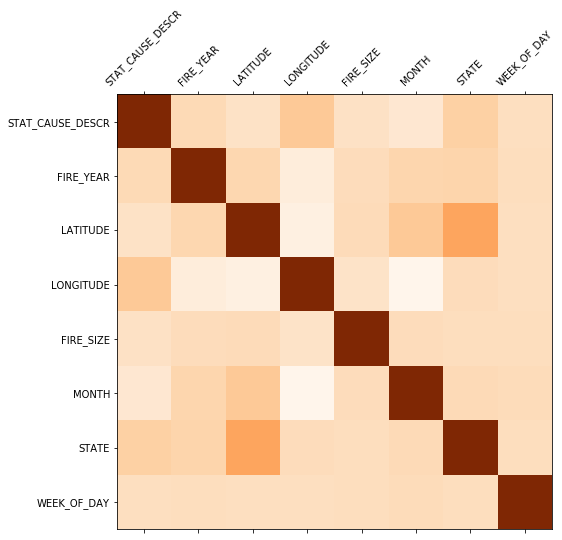

In [12]:
def plot_corr(df):
    corr = df3cats.corr()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.matshow(corr,cmap=plt.cm.Oranges)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)    
    plt.show()
    

    
plot_corr(df3cats)

# Use machine learning to predict the cause of the fires

In class, we've only learned how to predict categories (republican/democrat, die/live, true/false, etc.). For this project, we will convert "causes" to three categories:

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
import time

In [14]:
#MLPClassifier
start = time.time()
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
print('Accuracy: ' + str(mlp.score(X_test, y_test)))
end = time.time()
print('Run time: ' + str(end - start))

Accuracy: 0.6791674983919977
Run time: 294.21778893470764


## Random Forest Model


In [20]:
# show feature importances
def plot_feature_importances(columns, importances):
    # Convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
    f_importances = pd.Series(importances, columns)

    # Sort the array in descending order of the importances
    f_importances = f_importances.sort_values(ascending=False)

    # Draw the bar Plot from f_importances 
    f_importances.plot(x='Features', y='Importance', kind='bar', figsize=(16,9), rot=45, fontsize=30)
    
    plt.title('Feature Importances').set_fontsize(32)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

Accuracy: 0.690088051988378
Run time: 26.459707260131836


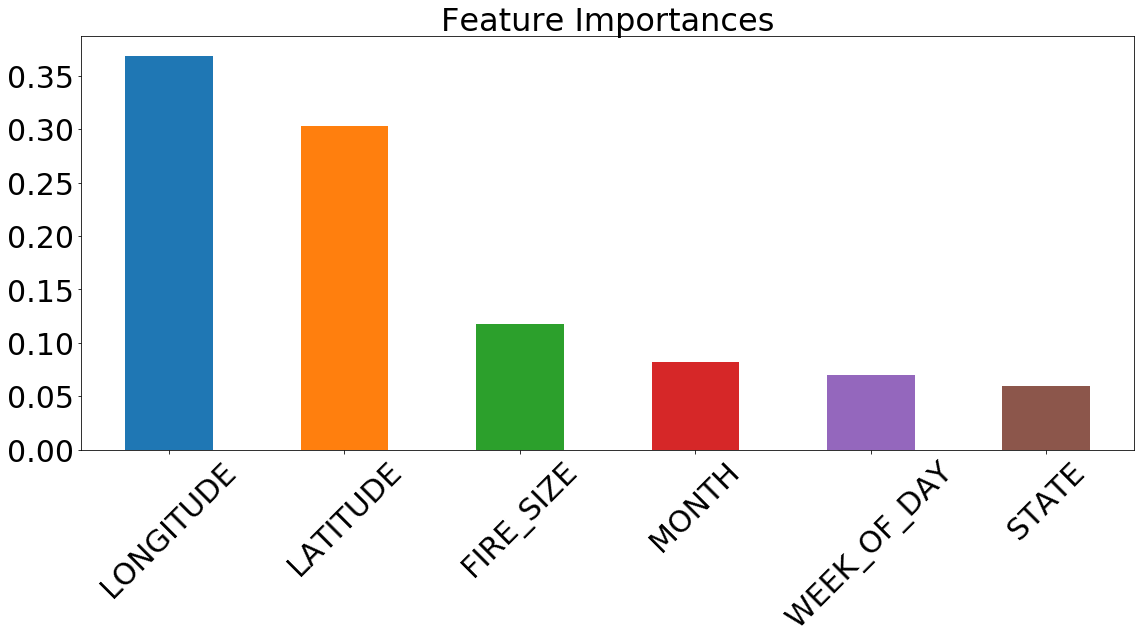

In [21]:
#RandomForestClassifier
start = time.time()
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print('Accuracy: ' + str(rfc.score(X_test, y_test)))
end = time.time()
print('Run time: ' + str(end - start))


# Plot feature importances
importances = rfc.feature_importances_
plot_feature_importances(features, importances)

In [16]:
#LogisticRegression
start = time.time()
lr = LogisticRegression()
lr.fit(X_train, y_train)
print('Accuracy: ' + str(lr.score(X_test, y_test)))
end = time.time()
print('Run time: ' + str(end - start))

Accuracy: 0.5626011932486082
Run time: 3.207022190093994


In [17]:
#DecisionTreeClassifier
start = time.time()
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
print('Accuracy: ' + str(dtc.score(X_test, y_test)))
end = time.time()
print('Run time: ' + str(end - start))

Accuracy: 0.6334919156297825
Run time: 7.435149192810059


In [18]:
#PCA
start = time.time()
pc = PCA()
pc.fit(X_train, y_train)
print('Accuracy: ' + str(pc.score(X_test, y_test)))
end = time.time()
print('Run time: ' + str(end - start))

Accuracy: -8.463944923423687
Run time: 0.24412298202514648


# Pipeline Method 

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [23]:
# name the classifiers
clfs = {'lr': LogisticRegression(class_weight='balanced', 
                                 random_state=0),        
        'mlp': MLPClassifier(random_state=0),
        'dt': DecisionTreeClassifier(class_weight='balanced', 
                                     random_state=0),
        'rf': RandomForestClassifier(class_weight='balanced', 
                                     random_state=0),
        }

# create the pipeline
pipe_clfs = {}

for name, clf in clfs.items():
    pipe_clfs[name] = {}
    pipe_clfs[name] = Pipeline([('StandardScaler', StandardScaler()), 
                                ('clf', clf)])



In [24]:
param_grids = {}

# 9.1.1 The parameter grid for logistic regression
C_range = [10 ** i for i in range(-5, 4)]
param_grid_lr = [{'clf__multi_class': ['ovr'], 
               'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
               'clf__C': C_range},
              {'clf__multi_class': ['multinomial'],
               'clf__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
               'clf__C': C_range}]
param_grids['lr'] = param_grid_lr

# 9.1.2 The parameter grid for multi-layer perceptron
param_grid_mlp = [{'clf__hidden_layer_sizes': [10, 100, 200], 
                   'clf__activation': ['identity', 'logistic', 'tanh', 'relu'],
                   'clf__solver': ['lbfgs','sgd','adam']}]
param_grids['mlp'] = param_grid_mlp

# 9.1.3 The parameter grid for decision tree
param_grid_dt = [{'clf__min_samples_split': [2, 10, 30], 
                  'clf__min_samples_leaf': [1, 10, 30], 
                  'clf__max_features': ['auto', 'sqrt', 'log2', None]}]
param_grids['dt'] = param_grid_dt

# 9.1.4 The parameter grid for random forest
param_grid_rf = [{'clf__n_estimators': [10, 50, 100, 150],
                  'clf__min_samples_split': [2, 10, 30],
                  'clf__min_samples_leaf': [1, 10, 30], 
                  'clf__max_features': ['auto', 'sqrt', 'log2', None]}]
param_grids['rf'] = param_grid_rf

In [ ]:
# Hyperparameter tuning

import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# The list of [best_score_, best_params_, best_estimator_]
best_score_param_estimators2 = []

# For each classifier
for name in pipe_clfs.keys():
    print('Running parameter combinations for classifier: ' + name)
    #for n_component in n_components:   
    # GridSearchCV
    gs2 = GridSearchCV(estimator=pipe_clfs[name], #[n_component],
                      param_grid=param_grids[name],
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=StratifiedKFold(n_splits=10,
                                         shuffle=True,
                                         random_state=0))
    print('. ', end=' ')
    # Fit the pipeline - this takes 20-30 mins to run
    gs2 = gs2.fit(x, y)

    # Update best_score_param_estimators
    best_score_param_estimators2.append([gs2.best_score_, 
                                        gs2.best_params_, 
                                        gs2.best_estimator_])
    print('Done with ' + name + '.')

Running parameter combinations for classifier: lr
.  Done with lr.
Running parameter combinations for classifier: mlp
.  

# I have to give up for this process. My dataset is huge, I did a similar process before, but this time, I waited like a half day, but still didn't get any result. 


In [ ]:
# Model Selection 

# Sort best_score_param_estimators in descending order of the best_score_
best_score_param_estimators3 = sorted(best_score_param_estimators3, \
                                     key=lambda x: x[0], reverse=True)

# For each [best_score_, best_params_, best_estimator_]
for best_score_param_estimator in best_score_param_estimators3:
    # Print out [best_score_, best_params_, best_estimator_], where best_estimator_ is a pipeline
    # Since we only print out the type of classifier of the pipeline
    print([best_score_param_estimator[0], best_score_param_estimator[1], \
           type(best_score_param_estimator[2].named_steps['clf'])], end='\n\n')


In [ ]:
# Predictions

winner3 = best_score_param_estimators3[0][2]
print("The winning estimator is: " + str(type(winner3.named_steps['clf'])))

print(winner3.score(X3, y3))
y3_pred = winner3.predict(X3)
print('Misclassified samples: %d' % (y3 != y3_pred).sum())
accuracy_score(y3, y3_pred)